In [40]:
# https://en.wikipedia.org/wiki/Q-learning
# https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/
# https://www.winstar.com/blog/how-to-play-blackjack-a-beginners-guide-to-rules-and-strategy/

In [41]:
import pickle
from collections import defaultdict
from functools import partial
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.toy_text.blackjack import *
import numpy as np
import random as rand
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
from blackjackenv import MyBlackJackEnv, ACTIONS
from pathlib import Path

In [42]:
class BlackjackBasicAgent:
        
    def get_optimal_action(self, env, state):
        player_sum = state[0]
        dealer_face = state[1]
        if len(env.player) == 2:
            if (player_sum == 10 or player_sum == 11) and dealer_face <= 9:
                return ACTIONS.DOUBLE_DOWN
            # if env.player == [8, 8] or env.player == [1, 1]:
            #     return 4
            
        if player_sum < 12:
            return 1
        elif 12 <= player_sum <= 16:
            if dealer_face >= 7 or dealer_face == 1:
                return 1
            else:
                return 0
        else:
            return 0

In [43]:
class BlackjackAgent:
    def __init__(
        self,
        env, 
        learning_rate = 0.01,
        random_action_rate = 1,
        random_action_rate_decay = 0.99,
        min_random_action_rate = 0.01,
        discount_factor = 0.95
    ):
        # self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))
        self.q_table = defaultdict(partial(np.zeros, env.action_space.n))
        self.alpha = learning_rate
        self.rar = random_action_rate
        self.min_rar = min_random_action_rate
        self.rar_decay = random_action_rate_decay
        self.discount = discount_factor
        
    def get_action(self, env, state):
        if env.hitorstand_only:
            max_action = 1
        else:
            if len(env.player) > 2:
                max_action = 1
            elif env.player[0] == env.player[1] and env.splitted == False:
                max_action = 4
            else:
                max_action = 3
            
        if rand.uniform(0, 1) <= self.rar:
            # action = env.action_space.sample()
            action = rand.choice(range(0, max_action+1))
        else:
            action = self.get_optimal_action(env, state, max_action=max_action)
 
        return action

    def get_optimal_action(self, env, state, max_action=4):
        return int(np.argmax(self.q_table[state][0:max_action+1]))
    
    def update(self, state, next_state, action, reward, terminated):
        if terminated:
            next_q_val = 0
        else:
            next_q_val = max(self.q_table[next_state])
            
        self.q_table[state][action] = (1 - self.alpha) * self.q_table[state][action] + \
                                    self.alpha * (reward + self.discount * next_q_val)

    def decay_rar(self):
        self.rar = max(self.min_rar, self.rar * self.rar_decay)

In [44]:
class Mode:
    TRAIN = "train"
    TEST = "test"

In [45]:
def play_one_hand(env, agent, mode=Mode.TRAIN, seed=None):
    state, info = env.reset(seed=seed)
    if mode == Mode.TRAIN:
        action = agent.get_action(env, state)
    elif mode == Mode.TEST:
        action = agent.get_optimal_action(env, state)
    
    if action != ACTIONS.SPLIT:
        done = False
        while not done:
            next_state, reward, terminated, truncated, info = env.step(action)
            if mode == Mode.TRAIN:
                agent.update(state, next_state, action, reward, terminated)
                state = next_state
                action = agent.get_action(env, state)
                
            elif mode == Mode.TEST:
                state = next_state
                action = agent.get_optimal_action(env, state)

            done = terminated or truncated

        return reward
    
    elif action == ACTIONS.SPLIT:
        env.splitted = True
        card = env.player[0]
        start_state = state
        total_reward = 0

        for _ in range(2):
            done = False
            env.player = [card, draw_card(env.np_random)]
            state, _ = env._get_obs(), {}
            while not done:
                if mode == Mode.TRAIN:
                    action = agent.get_action(env, state)
                elif mode == Mode.TEST:
                    action = agent.get_optimal_action(env, state)

                next_state, reward, terminated, truncated, info = env.step(action)
                if mode == Mode.TRAIN:
                    agent.update(state, next_state, action, reward, terminated)
                done = terminated or truncated
                state = next_state
            
            total_reward += reward
            
        if mode == Mode.TRAIN:     
            agent.update(start_state, None, ACTIONS.SPLIT, total_reward, True)

        return total_reward

In [46]:
def get_or_train(filename, train_fn, *build_args, overwrite=False, **build_kwargs):
    out_dir = Path("pkl")
    out_dir.mkdir(exist_ok=True)
    path = out_dir / filename
    if path.exists() and not overwrite:
        print(f"[load] {path}")
        with path.open("rb") as f:
            return pickle.load(f)

    print(f"[train] {path} not found – creating new agent.")
    obj = train_fn(*build_args, **build_kwargs)

    with path.open("wb") as f:
        pickle.dump(obj, f)
    print(f"[save] {path}")

    return obj

In [47]:
def train_agent(env, epochs, random_action_rate_decay):
    agent = BlackjackAgent(env, random_action_rate_decay=random_action_rate_decay)
    for epoch in tqdm(range(epochs)):
        play_one_hand(env, agent, mode=Mode.TRAIN, seed=epoch)
        agent.decay_rar()

    if not env.hitorstand_only:
        for state, vals in agent.q_table.items():
            if state[2] == 0 and state[0] % 2 != 0:
                agent.q_table[state][ACTIONS.SPLIT] = -np.inf
            elif state[2] == 1 and state[0] != 12:
                agent.q_table[state][ACTIONS.SPLIT] = -np.inf
            
    return agent

In [48]:
EPOCHS = 50000000
half_life_action_rate = 0.1
random_action_rate_decay = np.exp(np.log(1/2) / (EPOCHS * half_life_action_rate))

env_all = MyBlackJackEnv(sab=True)
agent_allactions = get_or_train(
    "agent_allactions.pkl",
    train_agent,
    env_all, EPOCHS, random_action_rate_decay,
    overwrite=False
)

env_hs = MyBlackJackEnv(sab=True, hitorstand_only=True)
agent_hitorstand = get_or_train(
    "agent_hitorstand.pkl",
    train_agent,
    env_hs, EPOCHS, random_action_rate_decay,
    overwrite=False
)

[load] pkl/agent_allactions.pkl
[load] pkl/agent_hitorstand.pkl


In [49]:
def plot_strategy(q_table, title=""):
    player_vals = np.array([key[0] for key in q_table.keys()])
    dealer_vals = np.array([key[1] for key in q_table.keys()])
    action_vals = np.array([max(value) for value in q_table.values()])
    actions = np.array([np.argmax(value) for value in q_table.values()])
    
    mask = player_vals <= 21
    player_vals = player_vals[mask]
    dealer_vals = dealer_vals[mask]
    action_vals = action_vals[mask]
    actions = actions[mask]
    
    fig = plt.figure(figsize=(20, 10))    
    
    ax1 = fig.add_subplot(121, projection='3d')
    surf = ax1.plot_trisurf(dealer_vals, player_vals, action_vals, cmap='viridis', edgecolor='none')

    ax1.set_ylim(min(player_vals), 21)
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    x_ticks = np.arange(1, 11, 1)
    ax1.set_xticks(x_ticks)
    x_labels = [str(x) for x in x_ticks]
    x_labels[0] = 'A'
    ax1.set_xticklabels(x_labels)
    
    # Add labels and title
    ax1.set_xlabel('Dealer Upcard')
    ax1.set_ylabel('Player Sum')
    ax1.set_zlabel('Optimal Action value')
    
    df = pd.DataFrame({
        'Player Sum': player_vals,   
        'Dealer Upcard': dealer_vals,  
        'actions': actions,
    })
    
    df = df[df['Player Sum'] <= 21]

    heatmap_data = df.pivot(index='Dealer Upcard', columns='Player Sum', values='actions')
    
    ax2 = fig.add_subplot(122)
    n_actions = max(actions) + 1
    cmap = mpl.colors.ListedColormap(sns.color_palette("viridis", n_actions))
    boundaries = np.arange(-0.5, n_actions + 0.5, 1)
    norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)
    cax = fig.add_axes([1.01, 0.25, 0.025, 0.5])
    
    hm = sns.heatmap(
            heatmap_data,
            annot=True,
            cmap=cmap,
            norm=norm,
            ax=ax2,
            cbar=True,
            cbar_ax=cax)
    
    # label bar ticks
    cbar = hm.collections[0].colorbar
    cbar.set_ticks(range(n_actions))
    if n_actions == 5:
        ticklabels = ["0 Stand", "1 Hit", "2 Double", "3 Surrender", "4 Split"]
    elif n_actions == 2:
        ticklabels = ["0 Stand", "1 Hit"]
                         
    cbar.set_ticklabels(ticklabels)
    
    fig.suptitle(title, fontsize=20, ha='center')
    fig.tight_layout() 
    fig.colorbar(surf, shrink=0.3, aspect=5)

    # Save image
    base_dir = Path.cwd().parent      
    out_dir  = base_dir / "image"
    out_dir.mkdir(exist_ok=True)
    outfile = out_dir / f"{title}.png"
    fig.savefig(outfile, dpi=300, bbox_inches="tight")
    print(f"[saved] {outfile}")
    
    plt.show()

/var/folders/0q/bljmklsj56xbqmyw9zzkry2h0000gn/T/ipykernel_56603/1742511565.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


[saved] /Users/ZiyanLai/Dropbox/Files/MFE/Independent Projects/Q-Learning for Blackjack/image/Hit-or-Stand Agent: Soft Hand.png


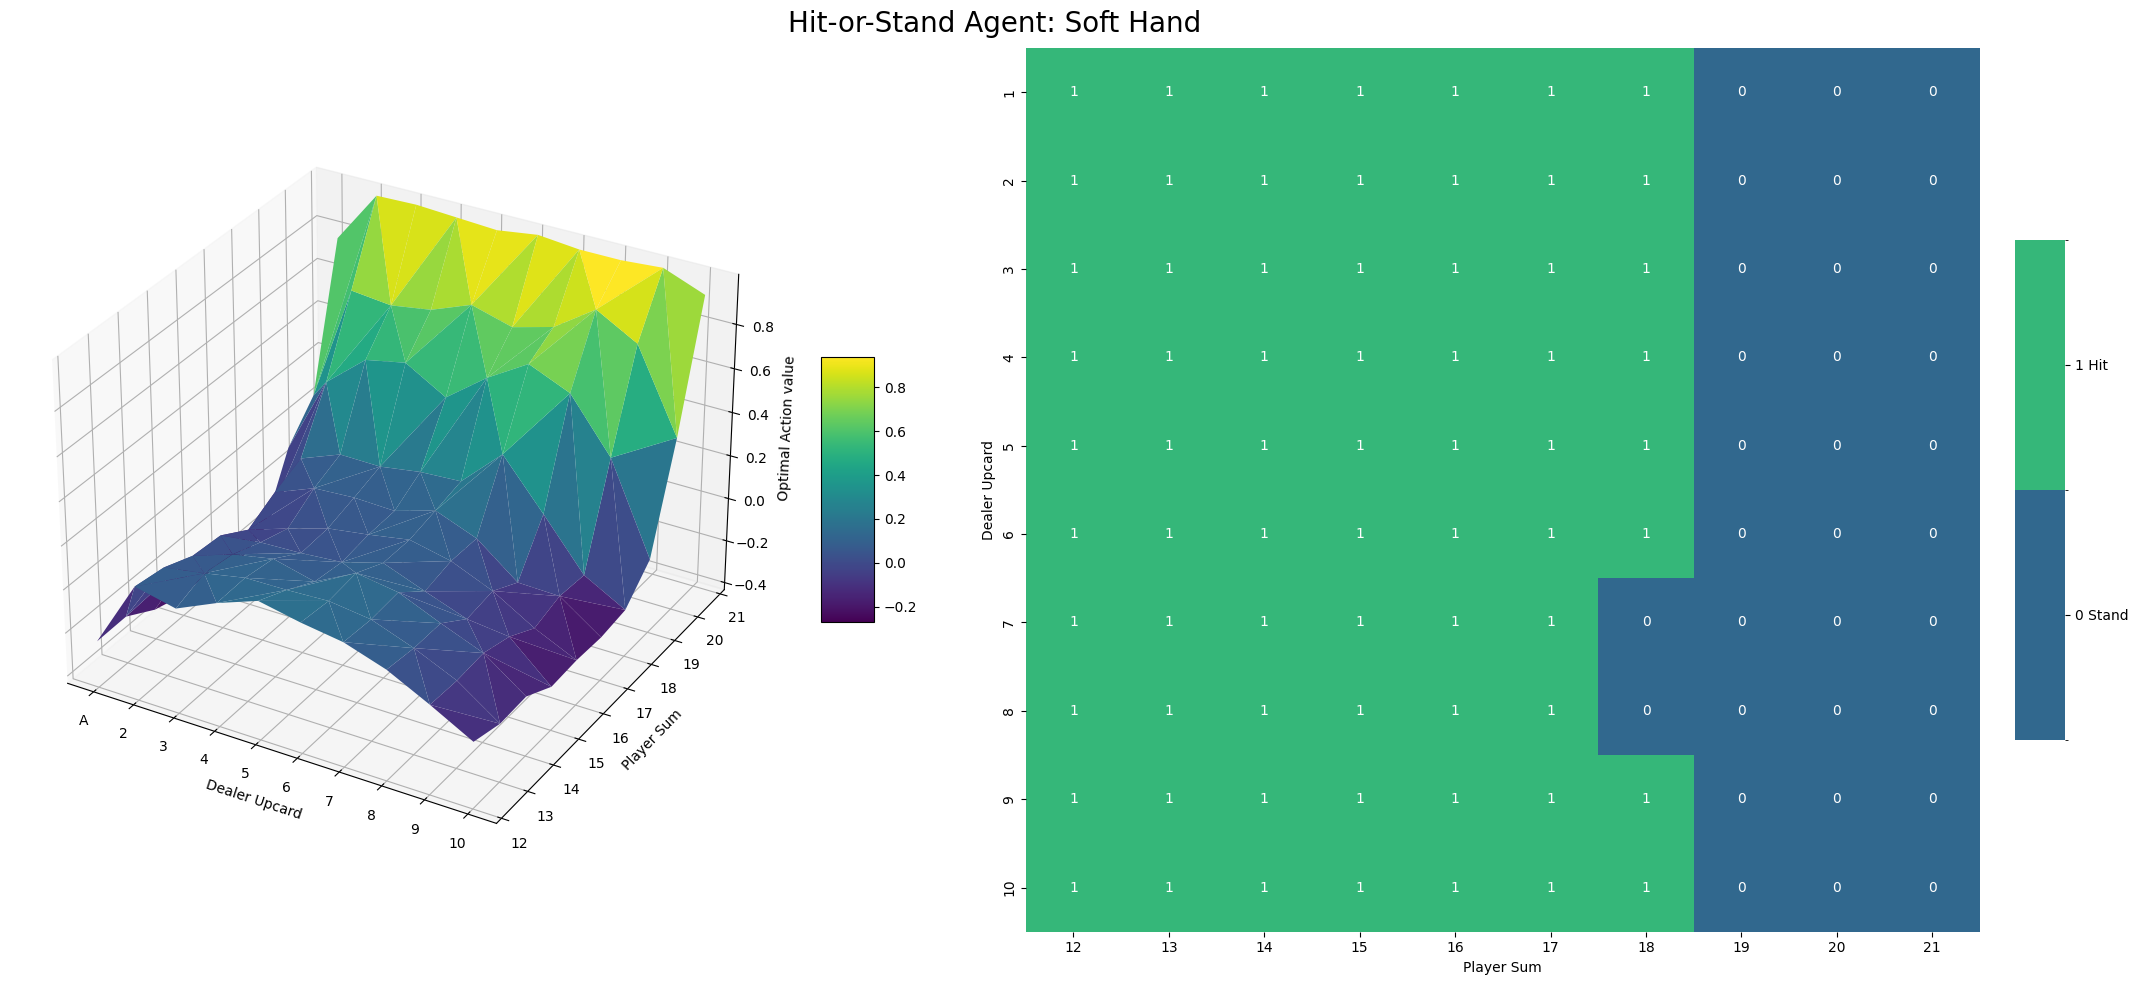

/var/folders/0q/bljmklsj56xbqmyw9zzkry2h0000gn/T/ipykernel_56603/1742511565.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


[saved] /Users/ZiyanLai/Dropbox/Files/MFE/Independent Projects/Q-Learning for Blackjack/image/Hit-or-Stand Agent: Hard Hand.png


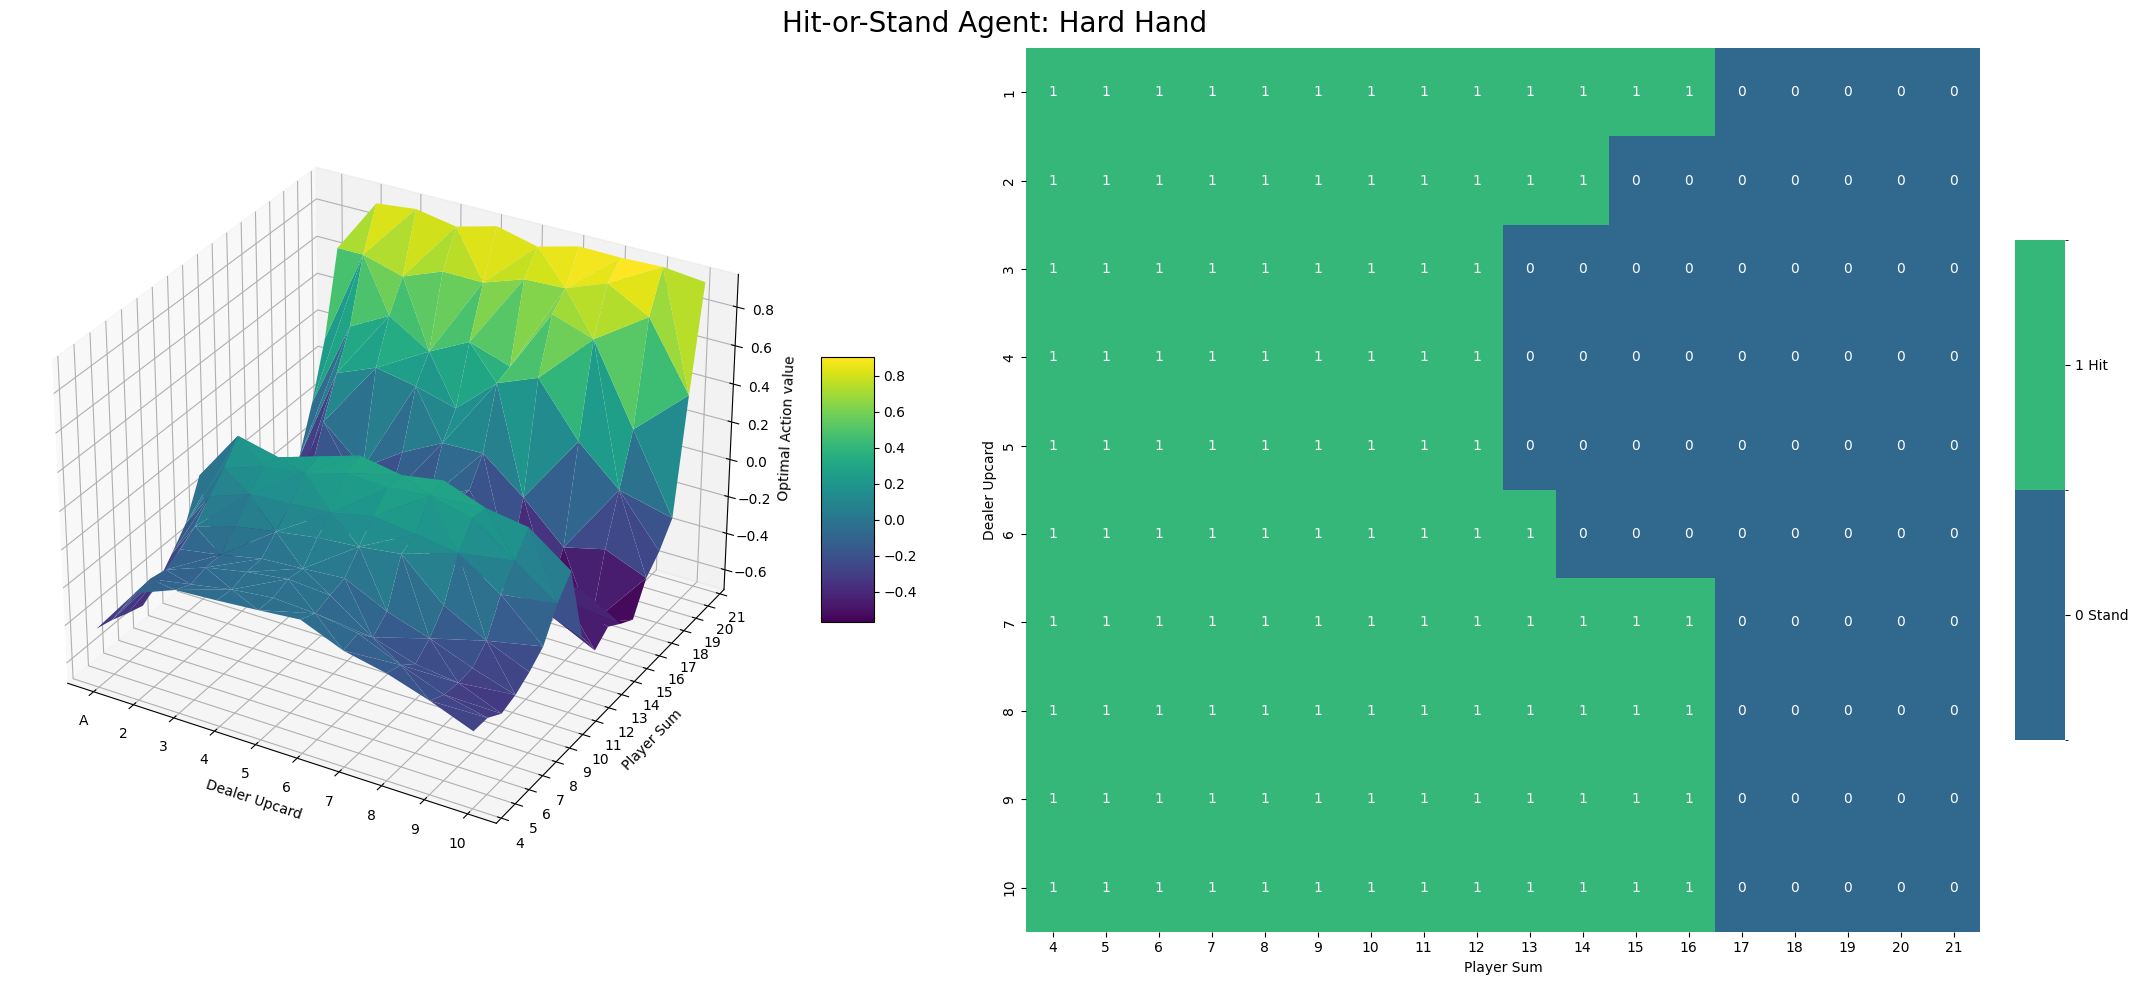

In [50]:
with_aces = {k: v for k, v in agent_hitorstand.q_table.items() if k[2] == 1}
without_aces = {k: v for k, v in agent_hitorstand.q_table.items() if k[2] == 0}

plot_strategy(with_aces, title="Hit-or-Stand Agent: Soft Hand")
plot_strategy(without_aces, title = "Hit-or-Stand Agent: Hard Hand")

/var/folders/0q/bljmklsj56xbqmyw9zzkry2h0000gn/T/ipykernel_56603/1742511565.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


[saved] /Users/ZiyanLai/Dropbox/Files/MFE/Independent Projects/Q-Learning for Blackjack/image/All-Actions Agent: Soft Hand.png


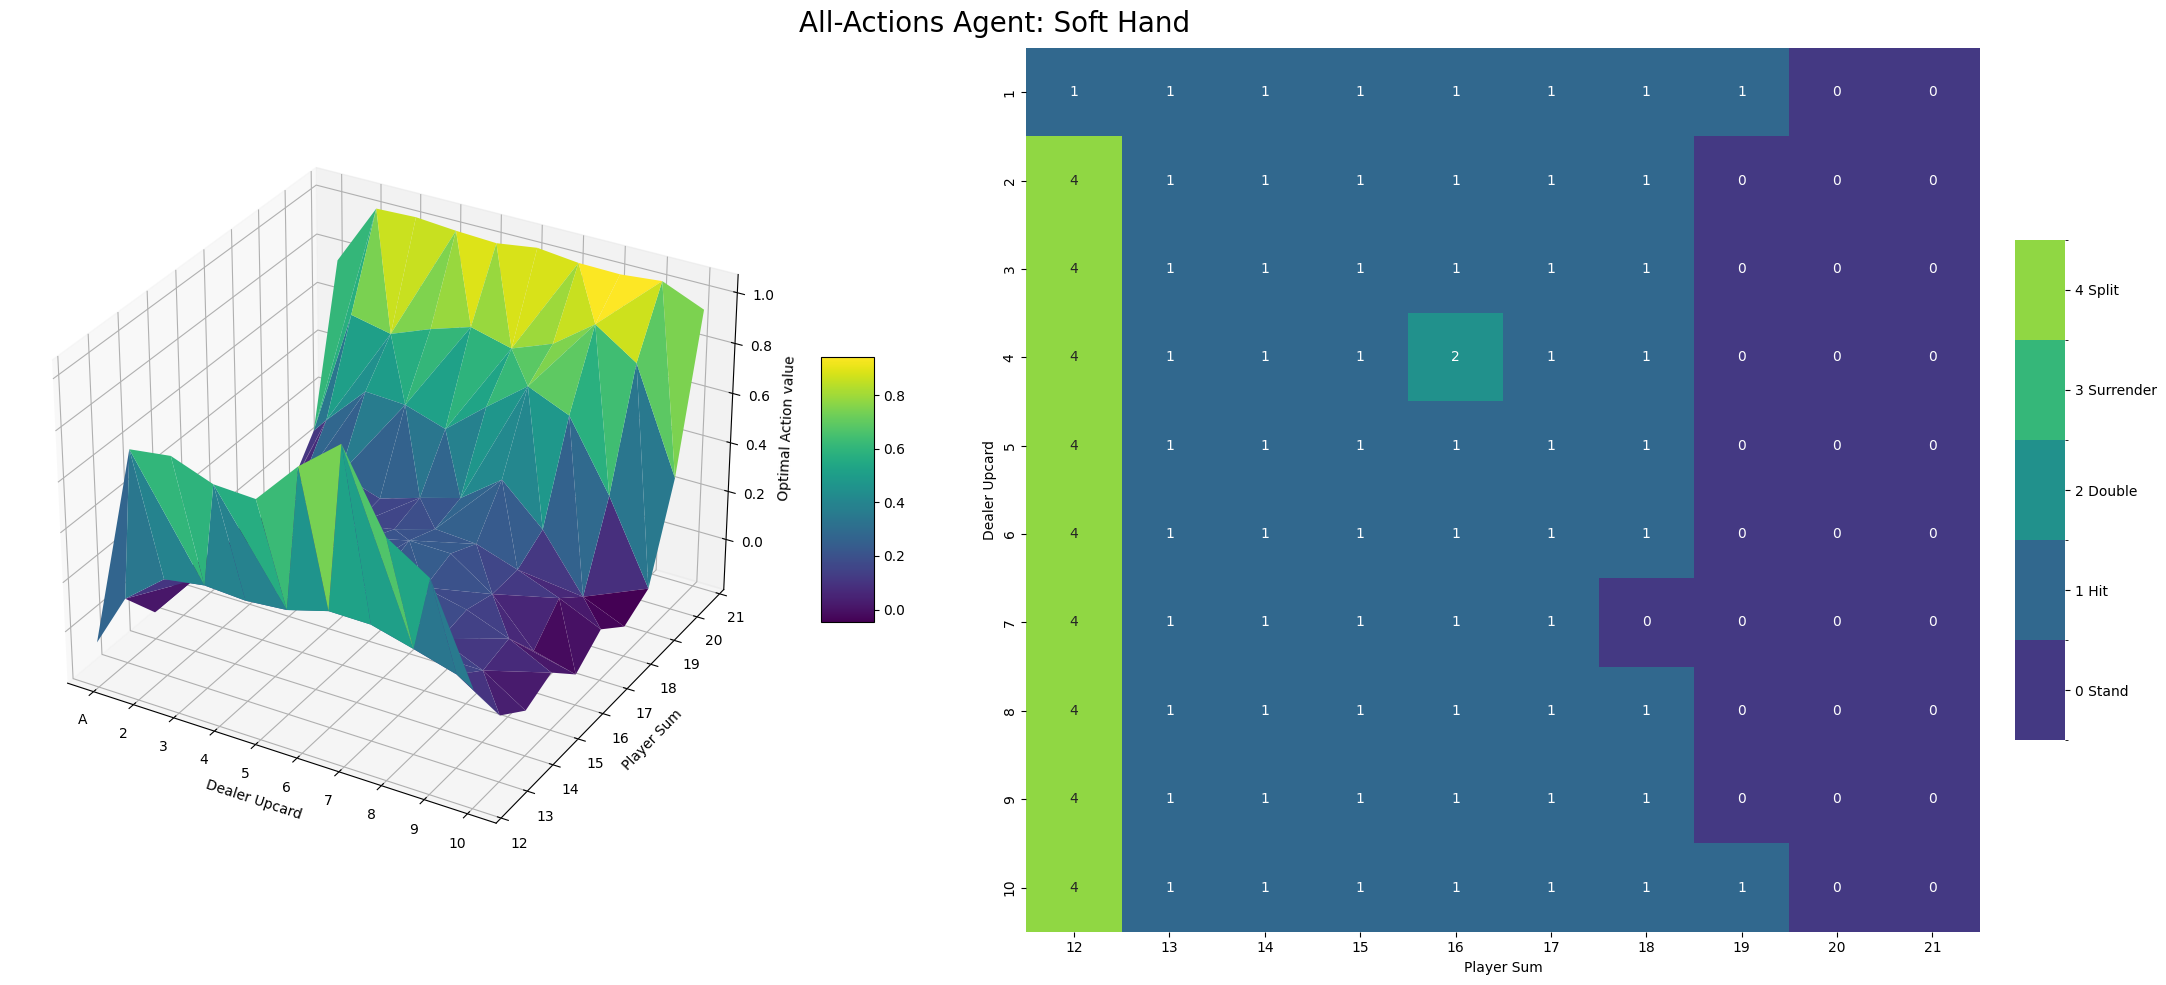

/var/folders/0q/bljmklsj56xbqmyw9zzkry2h0000gn/T/ipykernel_56603/1742511565.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


[saved] /Users/ZiyanLai/Dropbox/Files/MFE/Independent Projects/Q-Learning for Blackjack/image/All-Actions Agent: Hard Hand.png


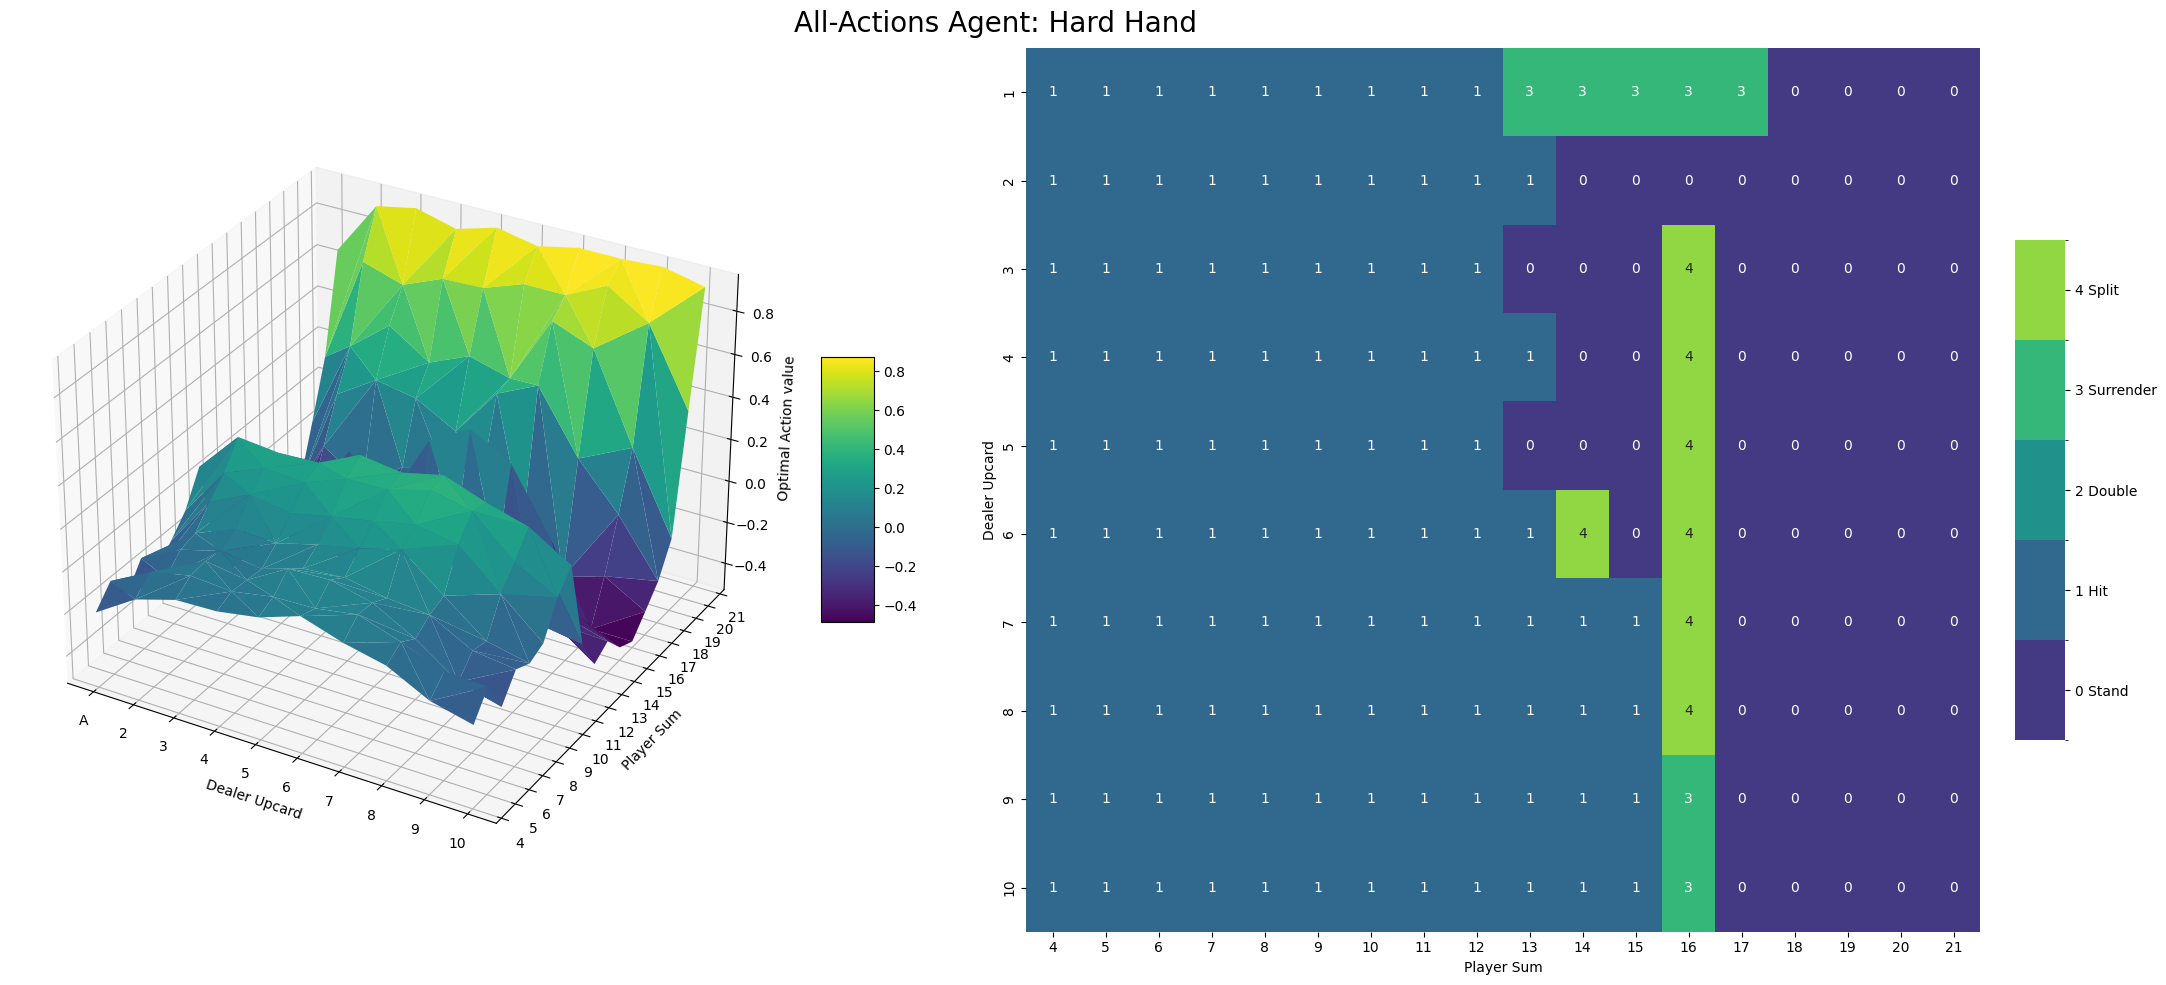

In [51]:
with_aces = {k: v for k, v in agent_allactions.q_table.items() if k[2] == 1}
without_aces = {k: v for k, v in agent_allactions.q_table.items() if k[2] == 0}

plot_strategy(with_aces, title="All-Actions Agent: Soft Hand")
plot_strategy(without_aces, title = "All-Actions Agent: Hard Hand")

In [52]:
num_games = 500000
rewards_allactions = []
for i in tqdm(range(num_games)):
    rewards_allactions.append(play_one_hand(env_all, agent_allactions, mode=Mode.TEST, seed=i+1))
rewards_allactions = np.array(rewards_allactions)

rewards_hitorstand = []
for i in tqdm(range(num_games)):
    rewards_hitorstand.append(play_one_hand(env_hs, agent_hitorstand, mode=Mode.TEST, seed=i+1))
rewards_hitorstand = np.array(rewards_hitorstand)

agent_basic = BlackjackBasicAgent()
rewards_basic = []
for i in tqdm(range(num_games)):
    rewards_basic.append(play_one_hand(env_all, agent_basic, mode=Mode.TEST, seed=i+1))
rewards_basic = np.array(rewards_basic)

100%|████████████████████████████████| 500000/500000 [00:28<00:00, 17366.18it/s]


In [53]:
def summarize_reward_sets(rewards_all_actions,
                          rewards_hit_stand,
                          rewards_basic,
                          strategy_names=("Basic", "Hit / Stand", "All Actions")
                         ):
    def _stats(arr):
        arr        = np.asarray(arr, dtype=float)
        n          = arr.size
        mean       = arr.mean()
        std        = np.std(arr)

        wins       = (arr > 0).sum()
        ties       = (arr == 0).sum()
        losses     = n - wins - ties

        win_rate   = wins   / n
        tie_rate   = ties   / n
        loss_rate  = losses / n

        return [n, mean, std, win_rate, tie_rate, loss_rate]

    data = [
        _stats(rewards_basic),
        _stats(rewards_hit_stand),
        _stats(rewards_all_actions),
    ]

    cols = ["Hands played",
            "Mean reward",
            "Std. deviation",
            "Win rate",
            "Tie rate",
            "Loss rate"]

    return pd.DataFrame(data, index=strategy_names, columns=cols)

In [54]:
summarize_reward_sets(rewards_allactions, rewards_hitorstand, rewards_basic)

,Hands played,Mean reward,Std. deviation,Win rate,Tie rate,Loss rate
Basic,500000,-0.043716,1.038239,0.428290,0.089144,0.482566
Hit / Stand,500000,-0.045226,0.950977,0.430588,0.093598,0.475814
All Actions,500000,-0.028347,0.952245,0.411656,0.098078,0.490266


In [55]:
def plot_agent_performance(outcomes, bins=15, title="Agent reward distribution"):
    mu   = outcomes.mean()  
    plt.figure(figsize=(8, 5))
    sns.histplot(outcomes, bins=bins, stat="density", kde=True, alpha=0.6, edgecolor="k")
    plt.axvline(mu, color="red", linestyle="--", linewidth=1.5, label=f"mean = {mu:.3f}")
    plt.title(title)
    plt.xlabel("Reward per hand")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

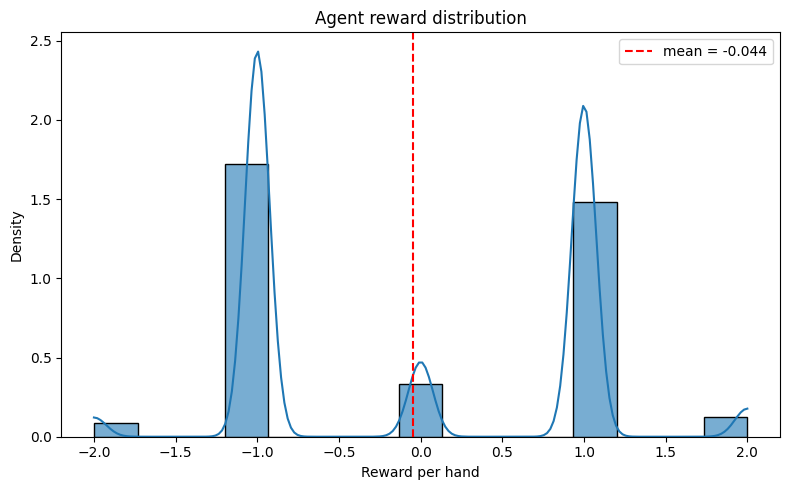

In [56]:
plot_agent_performance(rewards_basic)

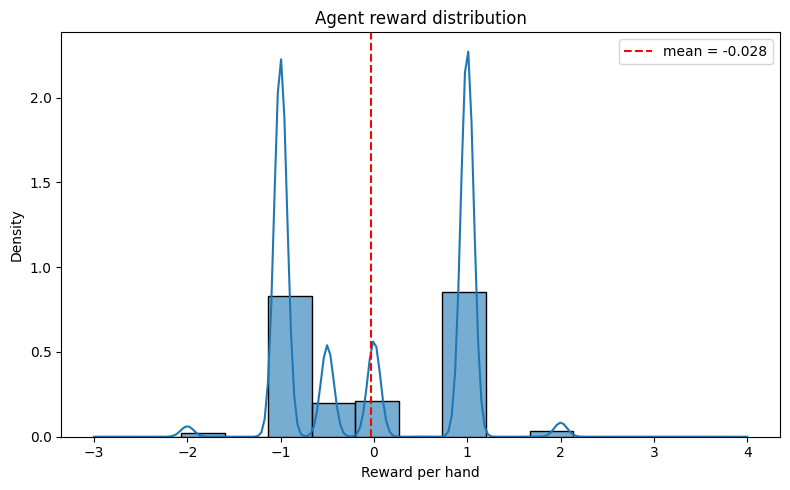

In [57]:
plot_agent_performance(rewards_allactions)

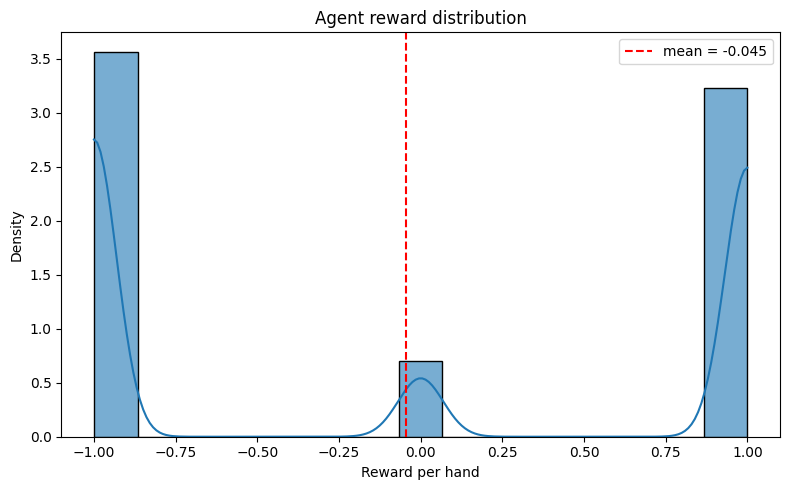

In [58]:
plot_agent_performance(rewards_hitorstand)